In [415]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

## The basic functionality we need

We will be using the idea of *total persistence* as in equation 1 (Rieck, 2016)

(**this is the tricky part**)

In [607]:
def total_persistence(data, metric = 'euclidean'):
    r = ripser(data,metric=metric)
    pers = 0
    for dgm in r['dgms']:
        pers += np.sum(np.abs(dgm[:-1,1] - dgm[:-1,0])**2) # the very last row always has an inf
    return pers

This is the ratio of explained persistence $\sigma_{\text{Global}}$ as defined in eq. 4

In [763]:
def explained_persistence(data,labels, metric = 'euclidean'):
    total = total_persistence(data, metric = metric)
    label_list = [i for i in np.unique(labels) if i>=0]
    explained = [total_persistence(data[labels==i], metric) for i in label_list]
    sns.barplot(x = label_list,y = explained/total)
    tep = np.sum(explained)/total
    plt.title('Pers = {:3.2f}, $\sigma_G = $ {:3.2f}% (metric = {})'.format(total,100*tep, metric))
    plt.ylabel('Label contribution')
    plt.xlabel('Labels')
    return tep

And this is just to plot multiple persistence diagrams side by side.

In [764]:
from ripser import ripser, plot_dgms

def plot_multiple_dgms(pcloud_list, names = None, metric = "euclidean"):
    n = len(pcloud_list)

    if names is None:
        names = ['$X_{}$'.format(i) for i in range(n-1)] + ["$X$"]
    plt.figure(figsize=(12,3))
    for i,pcloud in enumerate(pcloud_list):
        plt.subplot(100+10*n+i+1)
        r = ripser(pcloud,metric=metric)
        dgms = r['dgms']
        plot_dgms(dgms,lifetime = False)
        plt.title(names[i])
        
def plot_dgms_by_label(X, labels, metric = "euclidean"):
    pclouds = [X[labels ==i] for i in np.unique(labels) if i>=0]
    pclouds += [X]
    plot_multiple_dgms(pclouds, metric = metric)

# Experiment 1: Moons and blobs

Let's create some artificial data.

In [765]:
np.random.seed(33)
from sklearn import datasets
n = 45

X0,y0 = datasets.make_moons(n_samples=n, noise = 2e-2)
X1,y1 = datasets.make_blobs(n_samples=n)

X1 = 1 + X1 # X0 is zero centered, so for positioning of X1 relatively to X0
X = np.concatenate([X0,X1],axis=0)

Here we create two systems of labeling. `y` ranges over each individual component of $X_0$ and $X_1$; `z` simply marks 0 for $X_0$ and 1 for $X_1$.

In [766]:
y1 = len(np.unique(y0))+ y1 # for intra-subset label colors

z0 = np.zeros(y0.shape); z1 = 1 + np.zeros(y1.shape) # for labels only between subsets

y = np.concatenate([y0,y1],axis=0)
z = np.concatenate([z0,z1],axis=0)

The results

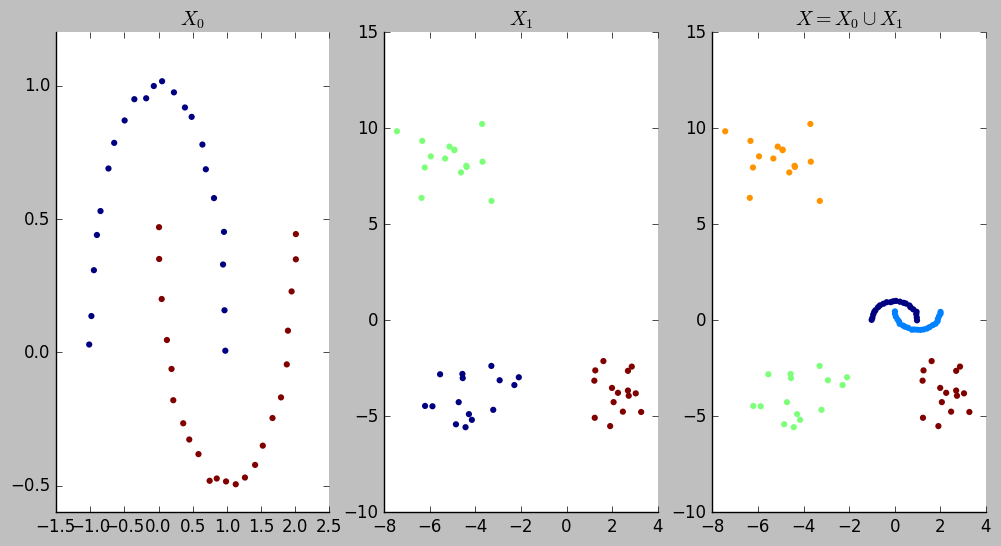

In [767]:
fig, ax = plt.subplots(ncols = 3, figsize = (12,6))
ax[0].scatter(X0[:,0],X0[:,1],c=y0,linewidth=0)
ax[1].scatter(X1[:,0],X1[:,1],c=y1,linewidth=0)
ax[2].scatter(X[:,0],X[:,1],c=y,linewidth=0)

sns.despine(fig)
for i,t in enumerate(['$X_0$', "$X_1$", "$X = X_0 \cup X_1$"]): ax[i].set_title(t)

These are the corresponding diagrams. 

TK (Some notes on how to interpret this diagram)

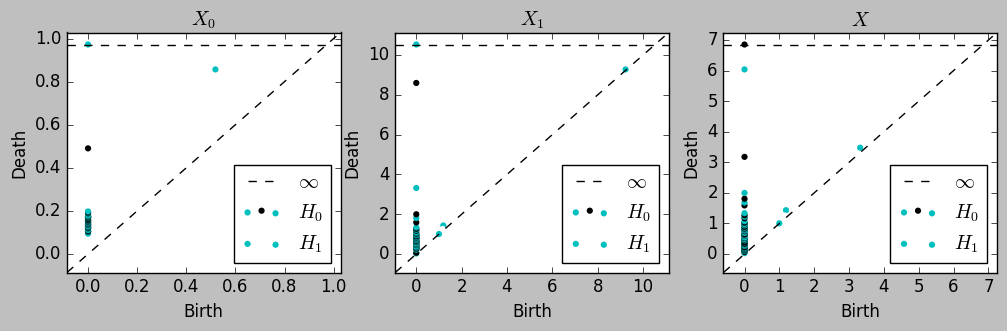

In [768]:
plot_multiple_dgms([X0,X1,X])

For example, the persistences of $X_0$ and $X_1$ explain some fraction of the persistence in $X$ (it's a mystery here that the persistence of label 1 seems higher than the total.

1.435821752857896

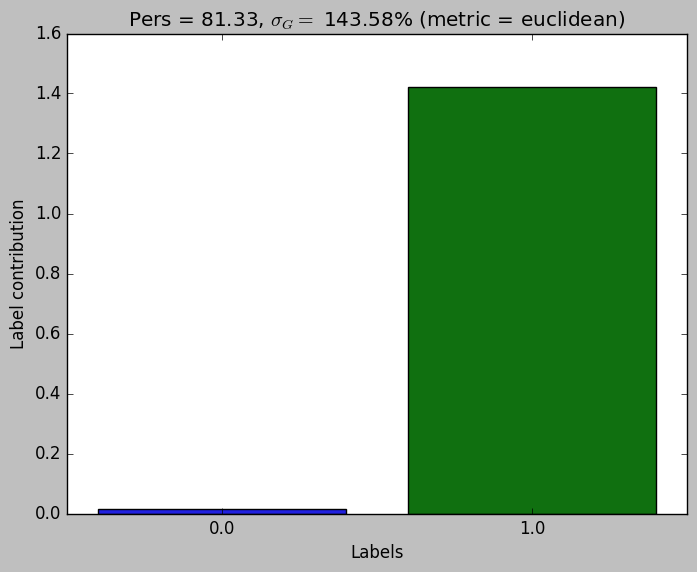

In [769]:
explained_persistence(X,z)

If we look at the persistence by intra-set labels this looks better. Last three clusters are blobs (parts of $X_1$) and still dominate

0.38551586719421843

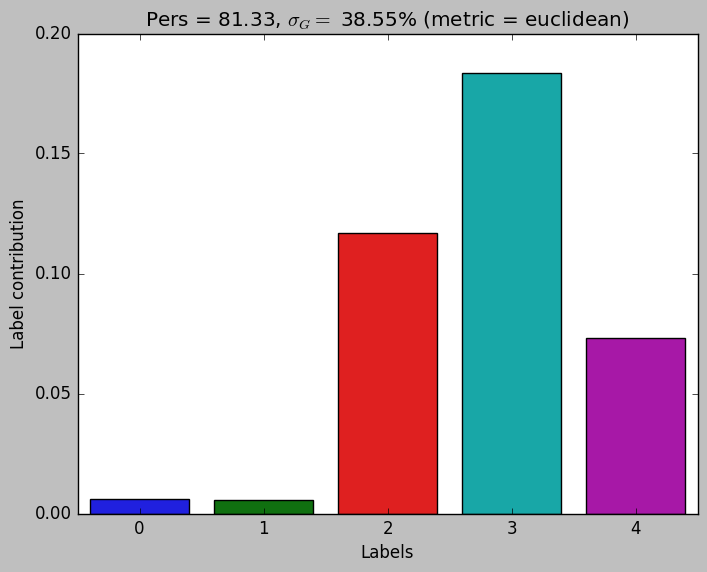

In [770]:
explained_persistence(X,y)

Now we study unsupervised decompositions of $X$ obtained by clustering. 

I'm first going to choose a clustering method that probably doesn't work well.

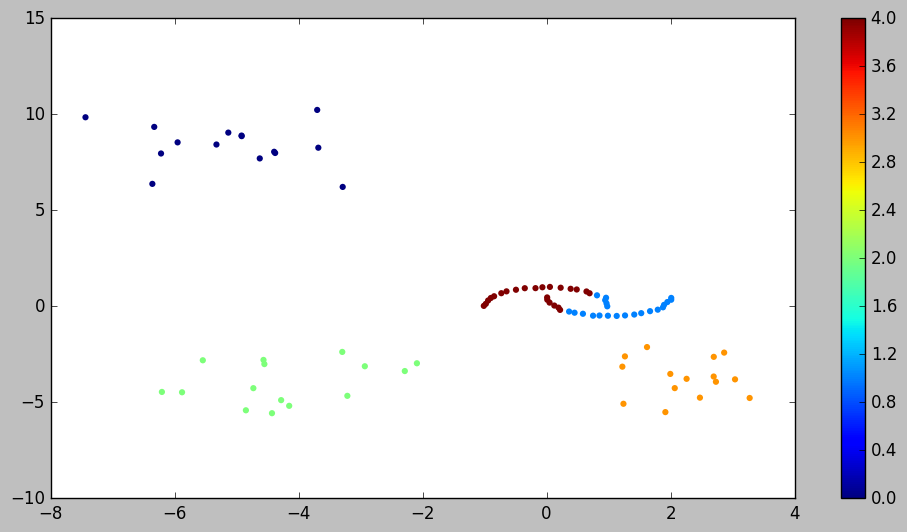

In [771]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=5)
kmeans_labels = clusterer.fit_predict(X)

fig, ax = plt.subplots(figsize=(12,6))
sc = ax.scatter(X[:,0],X[:,1], c = kmeans_labels,linewidth=0)
fig.colorbar(sc)

It actually works pretty well for separating blobs, it just doesn't separate the half moons. So how is this evaluated by explained persistance? *Somewhat better than the original labels!*

0.39110805100851487

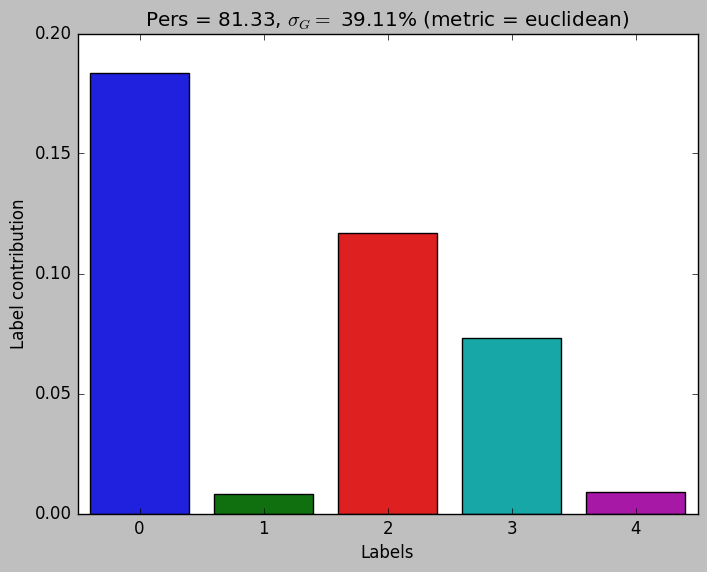

In [772]:
explained_persistence(X, kmeans_labels)

So let me try a fancier method that doesn't require me to specify a number of clusters to begin with.

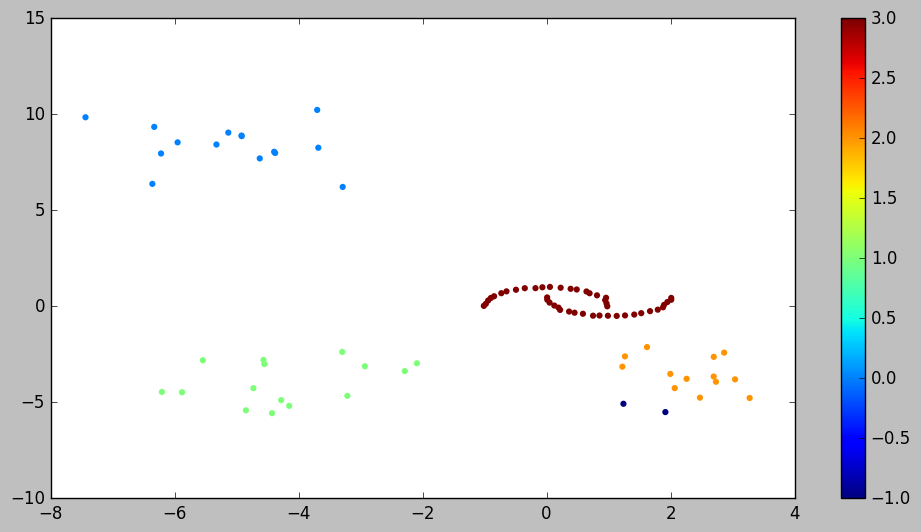

In [773]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN()
hdbscan_labels = clusterer.fit_predict(X)

fig, ax = plt.subplots(figsize=(12,6))
sc = ax.scatter(X[:,0],X[:,1], c = hdbscan_labels,linewidth=0)
fig.colorbar(sc)

It decides the half moons are not separate clusters. 

It looks worse by explained persistence, but at least most of the persistence is generated by the moons.

0.3696526463008341

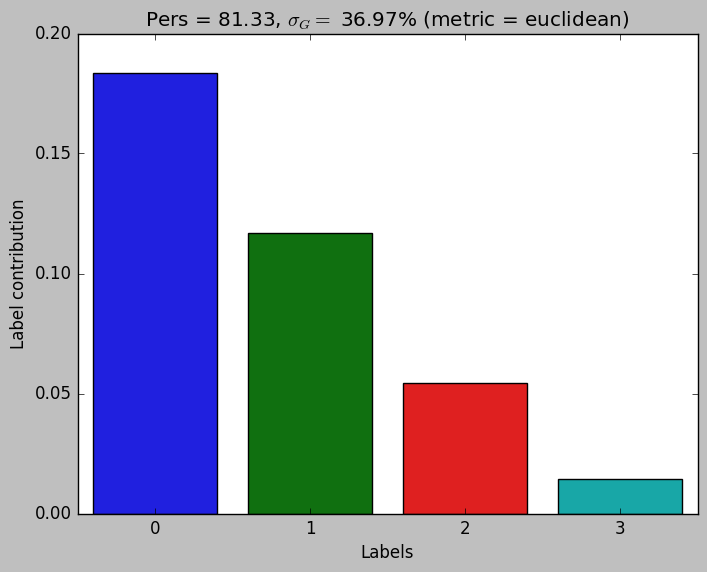

In [775]:
explained_persistence(X, hdbscan_labels)

Let's look for completeness at the persistence diagrams for this clustering.

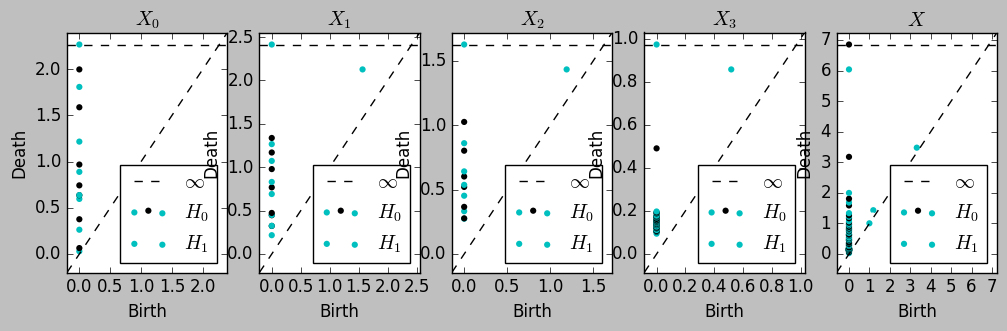

In [776]:
plot_dgms_by_label(X,hdbscan_labels)

----

## Experiment 2: Parallel moons

The moons on the left are noisier than the ones on the right.

In [777]:
np.random.seed(33)
from sklearn import datasets
n = 150

X0,y0 = datasets.make_moons(n_samples=n, noise = 5e-2)
X1,y1 = datasets.make_moons(n_samples=n, noise = 2.5e-2)


X1[:,0] = 4 + X1[:,0] # X0 is zero centered, so for positioning of X1 relatively to X0

X = np.concatenate([X0,X1],axis=0)

In [778]:
y1 = len(np.unique(y0))+ y1 # for intra-subset label colors

z0 = np.zeros(y0.shape); z1 = 1 + np.zeros(y1.shape) # for labels only between subsets

y = np.concatenate([y0,y1],axis=0)
z = np.concatenate([z0,z1],axis=0)

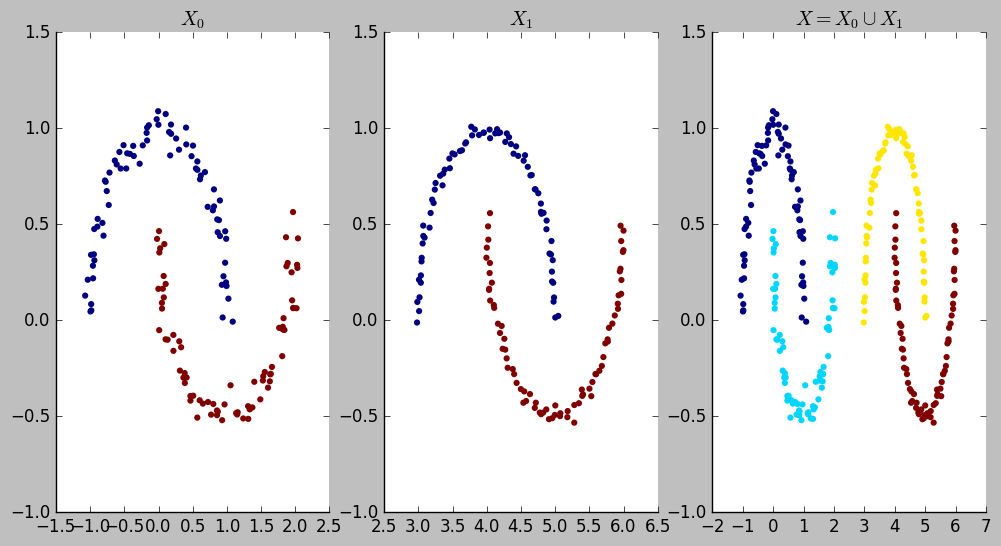

In [779]:
fig, ax = plt.subplots(ncols = 3, figsize = (12,6))
ax[0].scatter(X0[:,0],X0[:,1],c=y0,linewidth=0)
ax[1].scatter(X1[:,0],X1[:,1],c=y1,linewidth=0)
ax[2].scatter(X[:,0],X[:,1],c=y,linewidth=0)

sns.despine(fig)
for i,t in enumerate(['$X_0$', "$X_1$", "$X = X_0 \cup X_1$"]): ax[i].set_title(t)

The noisier components have a higher contribution to persistence.

0.4861867726017229

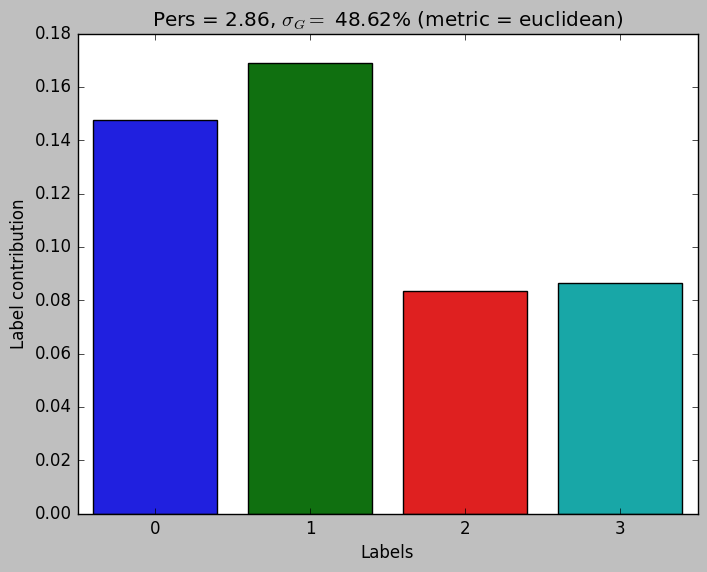

In [780]:
explained_persistence(X,y)

Also true if we label only by "moon on the left"/"moon on the right".

0.6745111567180663

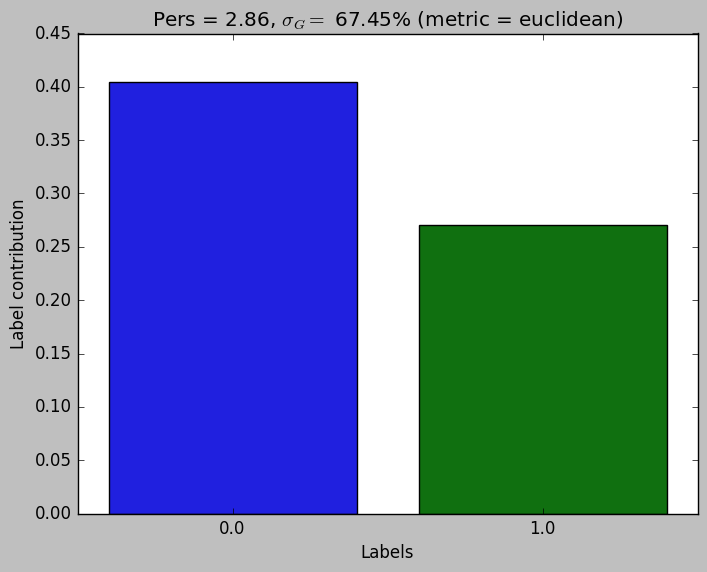

In [781]:
explained_persistence(X,z)

But note that more is explained by this coarser aggregation? Maybe the Rips filtration with euclidean metric doesn't make e.g. holes at some distance. Let's plot the diagrams itself (although I'm pretty sure it's producing white on white points).

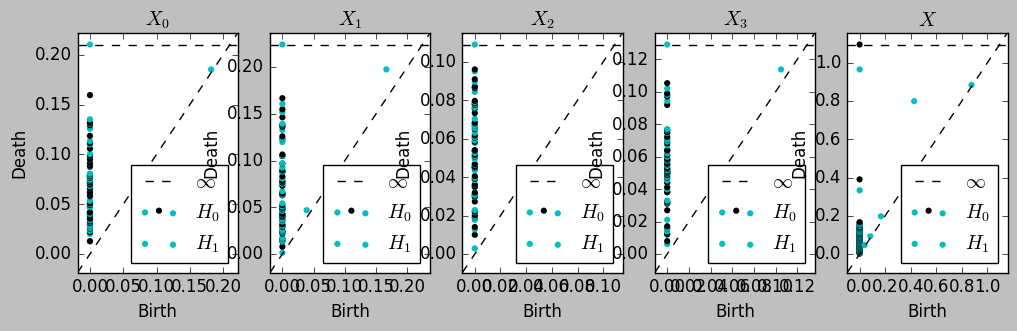

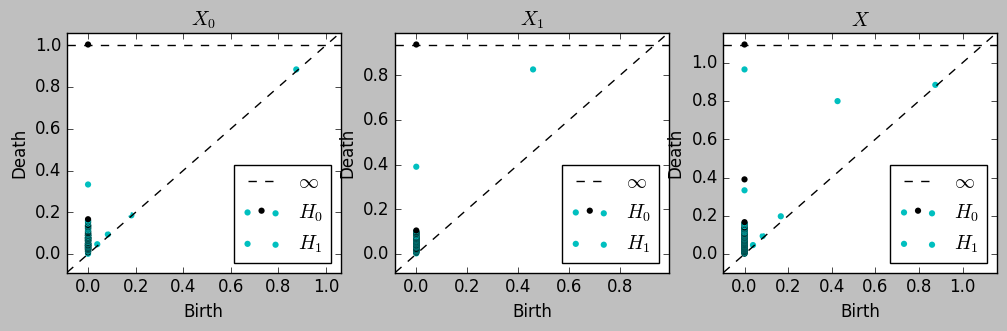

In [782]:
plot_dgms_by_label(X,y)
plot_dgms_by_label(X, z)

Let's try clustering. 

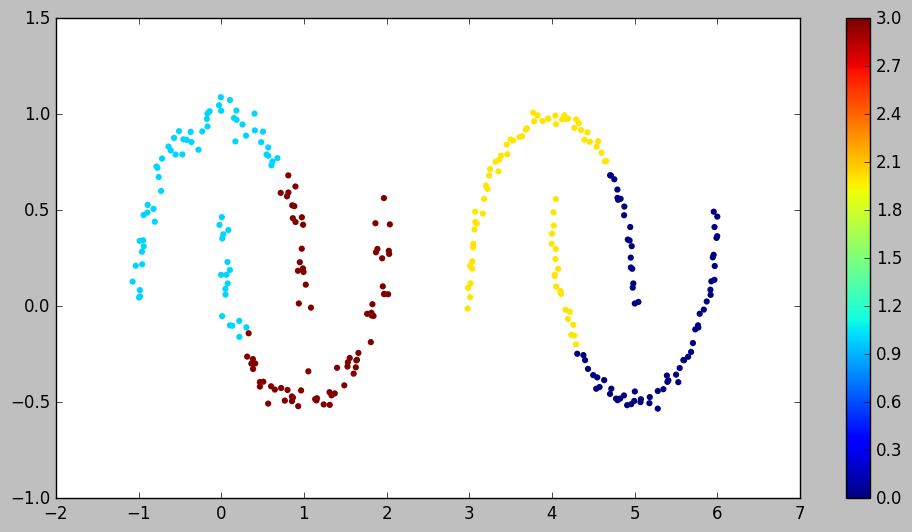

In [783]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4)
kmeans_labels = clusterer.fit_predict(X)

fig, ax = plt.subplots(figsize=(12,6))
sc = ax.scatter(X[:,0],X[:,1], c = kmeans_labels,linewidth=0)
fig.colorbar(sc)

0.7021406638477455

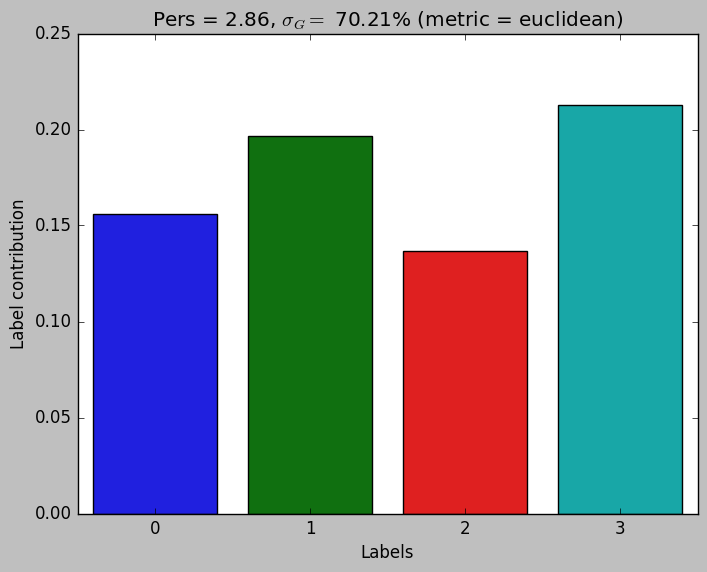

In [784]:
explained_persistence(X,kmeans_labels)

So, again, this non-good cluster assignment does *better* at explained variance than the true labels.

Let's plot for reference the diagrams for the true labels and the kmeans clustering

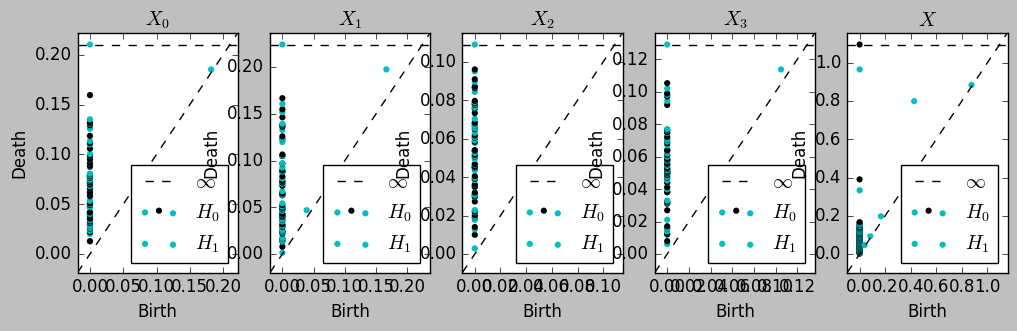

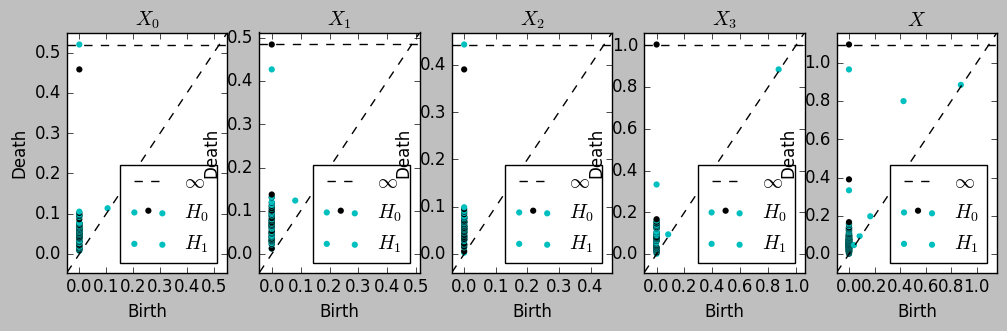

In [785]:
plot_dgms_by_label(X, y)
plot_dgms_by_label(X, kmeans_labels)

## Experiment 3: Iris data

In [786]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.data.shape, iris.target.shape

((150, 4), (150,))

0.8750635971003442

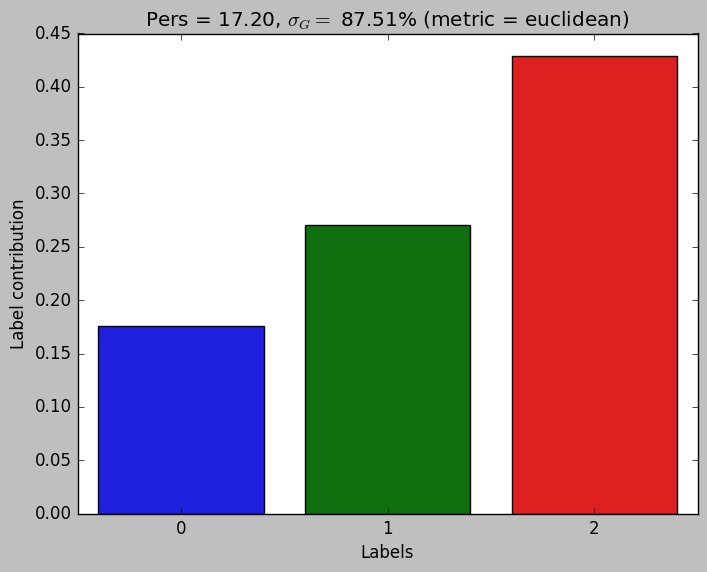

In [787]:
explained_persistence(iris.data,iris.target)

Why is the contribution of label 2 higher? Let's see first if there are class imbalances in the sample.

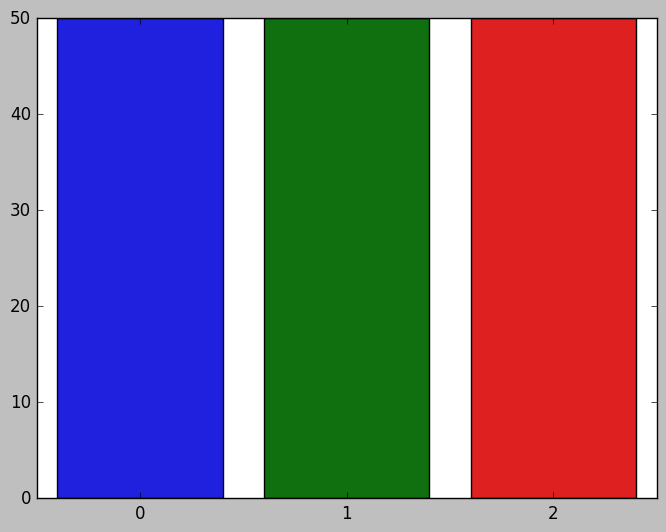

In [788]:
sns.barplot(x=np.unique(iris.target), y=[len(iris.data[iris.target==i]) for i in np.unique(iris.target)])

What about their characteriatic scale?

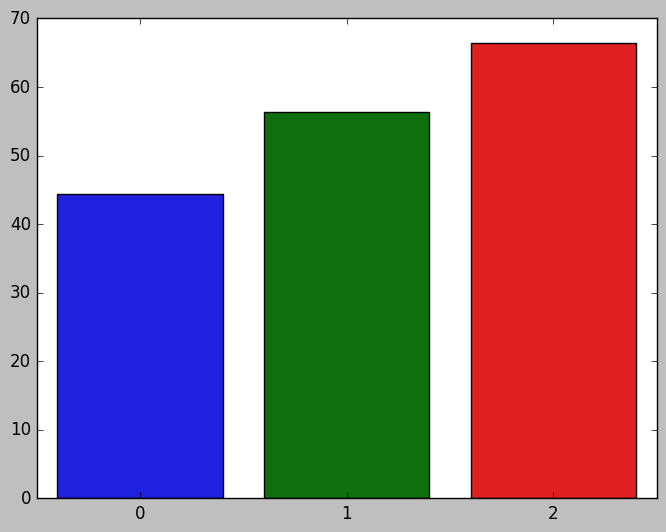

In [790]:
sns.barplot(x=np.unique(iris.target), y=[np.linalg.norm(iris.data[iris.target==i]) for i in np.unique(iris.target)])

Empirical conclusion: contribution to persistence is higher in the group with larger elements.

Let's try first to normaize by row (i.e. $x \mapsto x/\|x\|$)

0.5181859718180825

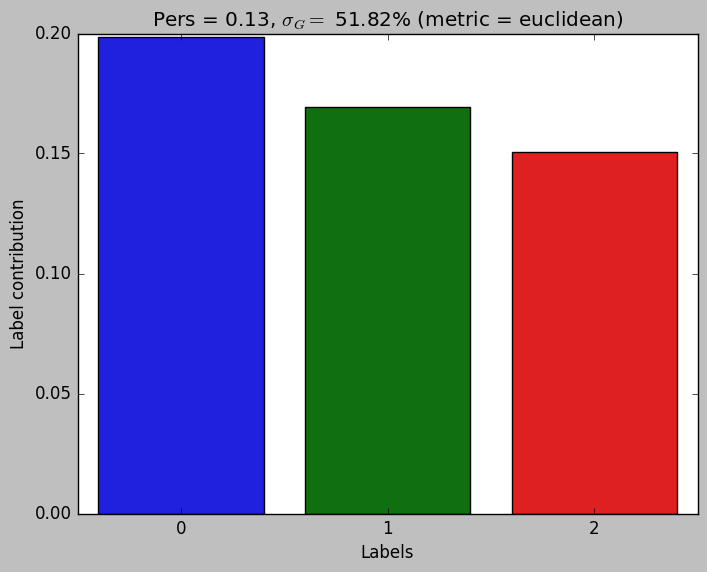

In [795]:
from sklearn.preprocessing import normalize

explained_persistence(normalize(iris.data),iris.target)

This changes the results but lowers the explained persistence. 
We can also try to standardize (set to mean 0, std. deviation 1)

0.9704906818268084

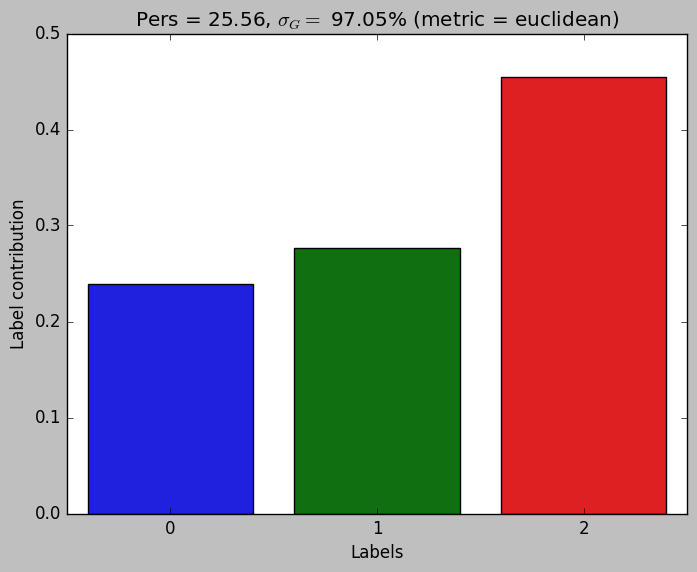

In [794]:
from sklearn.preprocessing import scale
explained_persistence(scale(iris.data),iris.target)

This improves explained variance and also attenuates the difference between group 1 and group 2.

Let's finally look at the diagrams for the original and the standardized data:

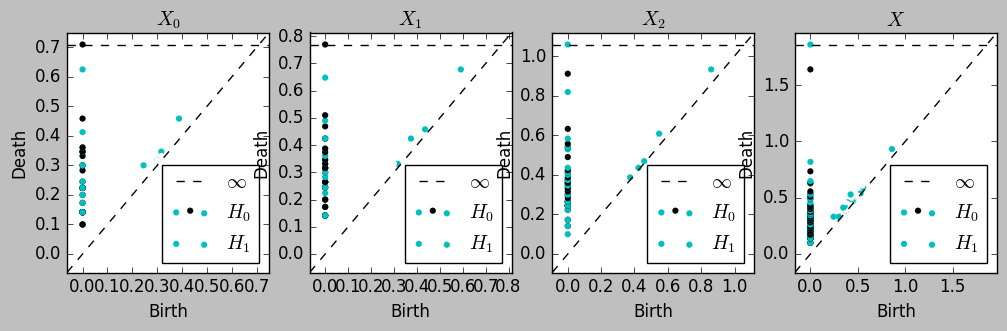

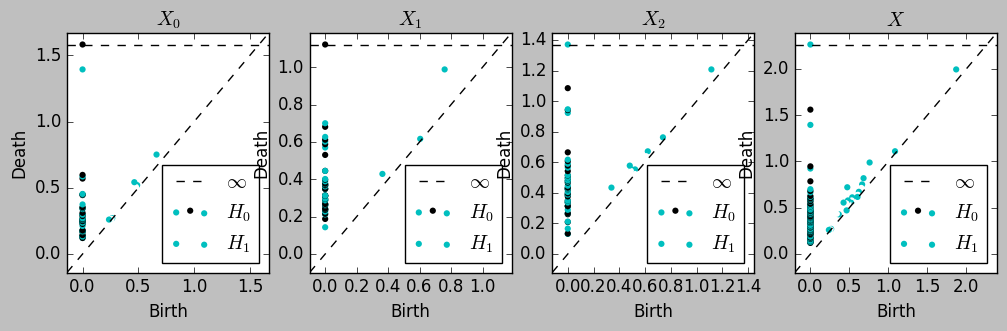

In [797]:
plot_dgms_by_label(iris.data, iris.target)
plot_dgms_by_label(scale(iris.data), iris.target)